# **<center> MAESTRÍA EN INGENIERÍA - ANALÍTICA**

**Estudiante:** Luis Felipe Ortiz

**Director** Sergio Armando Gutierrez Betancur. **Codirector** John Willian Branch Bedoya

**Proyecto:** Método para predicción de la intención de compra de usuarios en línea, utilizando técnicas de aprendizaje de máquina.


#**Definición del método predictivo: enfoque de ensamble de técnicas**

El método predictivo desarrollado combina dos técnicas de aprendizaje de máquina: Bosques Aleatorios y XGBoost. Estas técnicas fueron seleccionadas debido a su alto rendimiento en la métrica AUC  con valores de 0.93 y 0.92, respectivamente. El proceso de ensamble busca mejorar la precisión y robustez del sistema predictivo.

- **Ajustes de hiperparámetros**

Para optimizar el rendimiento de ambos modelos, se realizaron ajustes de hiperparámetros mediante una búsqueda en cuadrícula (GridSearchCV) con validación cruzada. La técnica de GridSearchCV ayuda a identificar las características más relevantes, reduciendo el impacto de las menos importantes.

*Bosques Aleatorios*

GridSearchCV: Se probaron 108 combinaciones de hiperparámetros, ajustando parámetros como el número de árboles (n_estimators), la profundidad máxima (max_depth) y la cantidad de características a considerar en cada división (max_features).

Características Importantes: Variables como PageValues y productRelated_Duration mostraron ser significativamente influyentes en la precisión del modelo.

*XGBoost*

GridSearchCV: Se ajustaron 81 combinaciones de hiperparámetros, optimizando parámetros como la tasa de aprendizaje (learning_rate), la proporción de muestras utilizadas en cada árbol (subsample) y el número de árboles.

Características Importantes: Además de PageValues, se destacó la variable Month, indicando la relevancia del tiempo y el comportamiento del usuario en diferentes períodos.

- **Codificación One-Hot**

El método one-hot encoding se utiliza para convertir características categóricas en una forma adecuada para los modelos de aprendizaje de máquina.

Cada categoría se convierte en una columna binaria independiente, lo que posibilita la gestión de datos categóricos sin suponer un orden inherente entre las categorías.

En este caso, la sobredimensionalidad no representa un problema ya que el número de categorías no es excesivamente grande. Particularmente, las técnicas XGBoost y Bosques Aleatorios poseen capacidad de gestionar gran número de características eficientemente.

**Ensamble de modelos**

El ensamble combina las salidas de múltiples modelos para mejorar la precisión y robustez del método predictivo.

**Técnicas de ensamble utilizadas**

* Votación: Se combinan las predicciones de ambos modelos y se elige la predicción final basada en la mayoría de votos.

* Stacking: Se utiliza un modelo meta-aprendizaje para aprender a partir de las predicciones de los modelos base (Bosques Aleatorios y XGBoost).


In [ ]:
# Montar Google Drive en Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del modelo y el pipeline
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Ajuste de hiperparámetros con búsqueda en grilla
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluación en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores hiperparámetros: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.7}
Precisión: 0.8771289537712895
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.88      0.99      0.93      2055
        True       0.87      0.31      0.46       411

    accuracy                           0.88      2466
   macro avg       0.87      0.65      0.69      2466
weighted avg       0.88      0.88      0.85      2466



**Pruebas y ajustes**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del pipeline con balanceo de clases
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state=42)),
    ('model', model)
])

# Ajuste de hiperparámetros con búsqueda en grilla
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("AUC-ROC:", roc_auc)
print("Informe de clasificación:\n", classification_rep)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores hiperparámetros: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.7}
Precisión: 0.8710462287104623
AUC-ROC: 0.8437956204379562
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.96      0.88      0.92      2055
        True       0.58      0.80      0.67       411

    accuracy                           0.87      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.89      0.87      0.88      2466



ajuste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
import numpy as np

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Ingeniería de características de comportamiento de usuarios # En este caso se busca relacionar la duración vs producto
data['New_Feature'] = data['ProductRelated_Duration'] / (data['ProductRelated'] + 1)

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'New_Feature']  # Añadir la nueva característica
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del pipeline incluyendo balanceo de clases
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state=42)),
    ('model', model)
])

# Ajuste de hiperparámetros con búsqueda en grilla
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.05, 0.1, 0.15],
    'model__subsample': [0.6, 0.7, 0.8],
    'model__colsample_bytree': [0.6, 0.7, 0.8]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_

# Obtener probabilidades y calcular el umbral
y_scores = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precisions + recalls)
optimal_threshold = thresholds[optimal_idx]
print("Umbral óptimo:", optimal_threshold)

# Aplicar umbral
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_optimal)
classification_rep = classification_report(y_test, y_pred_optimal)

print("Precisión:", accuracy)
print("AUC-ROC:", roc_auc)
print("Informe de clasificación:\n", classification_rep)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

Mejores hiperparámetros: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.6}
Umbral óptimo: 0.54847294
Precisión: 0.8824006488240065
AUC-ROC: 0.8457420924574209
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.96      0.90      0.93      2055
        True       0.61      0.79      0.69       411

    accuracy                           0.88      2466
   macro avg       0.78      0.85      0.81      2466
weighted avg       0.90      0.88      0.89      2466



ajuste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Ingeniería de características
data['New_Feature'] = data['ProductRelated_Duration'] / (data['ProductRelated'] + 1)

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'New_Feature']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost con ajuste de hiperparámetros
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state=42)),
    ('model', model)
])

# Ajuste de hiperparámetros con búsqueda en grilla
param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("AUC-ROC:", roc_auc)
print("Informe de clasificación:\n", classification_rep)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

Mejores hiperparámetros: {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.6}
Precisión: 0.8706407137064072
AUC-ROC: 0.8425790754257907
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.96      0.88      0.92      2055
        True       0.58      0.80      0.67       411

    accuracy                           0.87      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.89      0.87      0.88      2466



AJUSTE

**ajuste**

In [ ]:
!pip install scikit-optimize


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del modelo y el pipeline
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# hiperparámetros espacio para optimización bayesiana
search_space = {
    'model__n_estimators': Integer(50, 300),
    'model__max_depth': Integer(3, 10),
    'model__learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'model__subsample': Real(0.5, 1.0),
    'model__colsample_bytree': Real(0.5, 1.0),
    'model__min_child_weight': Integer(1, 10)
}

# Optimización bayesiana
opt = BayesSearchCV(pipeline, search_space, n_iter=32, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Mejores hiperparámetros y evaluación del modelo
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Mejores hiperparámetros:", opt.best_params_)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Mejores hiperparámetros: OrderedDict([('model__colsample_bytree', 0.5), ('model__learning_rate', 0.12177031250602108), ('model__max_depth', 3), ('model__min_child_weight', 10), ('model__n_estimators', 50), ('model__subsample', 1.0)])
Precisión: 0.8925385239253852
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.92      0.96      0.94      2055
        True       0.73      0.57      0.64       411

    accuracy                           0.89      2466
   macro avg       0.82      0.76      0.79      2466
weighted avg       0.89      0.89      0.89      2466



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Pipeline con ADASYN para el balanceo de clases
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('model', model)
])

# Hiperparámetros para la optimización bayesiana
search_space = {
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(3, 10),
    'model__learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'model__subsample': Real(0.5, 1.0),
    'model__colsample_bytree': Real(0.5, 1.0),
    'model__min_child_weight': Integer(1, 10)
}

# Optimización bayesiana con validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(pipeline, search_space, n_iter=40, scoring='accuracy', cv=stratified_kfold, n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Mejores hiperparámetros y evaluación del modelo
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Mejores hiperparámetros:", opt.best_params_)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Mejores hiperparámetros: OrderedDict([('model__colsample_bytree', 0.6900418660423935), ('model__learning_rate', 0.10206878797398077), ('model__max_depth', 6), ('model__min_child_weight', 3), ('model__n_estimators', 209), ('model__subsample', 1.0)])
Precisión: 0.8957826439578265
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.95      0.94      2055
        True       0.71      0.64      0.67       411

    accuracy                           0.90      2466
   macro avg       0.82      0.79      0.80      2466
weighted avg       0.89      0.90      0.89      2466



ad

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Ingeniería de características avanzada
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Average_Duration'] = data['Total_Duration'] / (data['Administrative'] + data['Informational'] + data['ProductRelated'] + 1)
data['Bounce_Exit_Rate'] = data['BounceRates'] * data['ExitRates']
data['Administrative_Binary'] = (data['Administrative'] > 0).astype(int)

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
                    'Total_Duration', 'Average_Duration', 'Bounce_Exit_Rate', 'Administrative_Binary']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Pipeline con ADASYN para el balanceo de clases
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('model', model)
])

# Hiperparámetros para la optimización bayesiana
search_space = {
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(3, 10),
    'model__learning_rate': Real(0.01, 0.2, 'log-uniform'),
    'model__subsample': Real(0.5, 1.0),
    'model__colsample_bytree': Real(0.5, 1.0),
    'model__min_child_weight': Integer(1, 10)
}

# Optimización bayesiana con validación cruzada estratificada
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(pipeline, search_space, n_iter=40, scoring='accuracy', cv=stratified_kfold, n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

# Mejores hiperparámetros y evaluación del modelo
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Mejores hiperparámetros:", opt.best_params_)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Mejores hiperparámetros: OrderedDict([('model__colsample_bytree', 0.5261077767011795), ('model__learning_rate', 0.04894780838400718), ('model__max_depth', 4), ('model__min_child_weight', 1), ('model__n_estimators', 500), ('model__subsample', 1.0)])
Precisión: 0.8953771289537713
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.95      0.94      2055
        True       0.70      0.65      0.67       411

    accuracy                           0.90      2466
   macro avg       0.82      0.80      0.81      2466
weighted avg       0.89      0.90      0.89      2466



#**MÉTODO DE PREDICCIÓN**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import ADASYN

# Carga del conjunto de datos
file_path = '/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv'
data = pd.read_csv(file_path)

# Ingeniería de características avanzada
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Total_Pages'] = data['Administrative'] + data['Informational'] + data['ProductRelated']
data['Pages_Per_Duration'] = data['Total_Pages'] / (data['Total_Duration'] + 1)
data['Admin_Duration_Ratio'] = data['Administrative_Duration'] / (data['Total_Duration'] + 1)
data['Info_Duration_Ratio'] = data['Informational_Duration'] / (data['Total_Duration'] + 1)
data['Product_Duration_Ratio'] = data['ProductRelated_Duration'] / (data['Total_Duration'] + 1)
data['Page_Bounce_Exit_Ratio'] = data['PageValues'] * data['BounceRates'] * data['ExitRates']
data['Admin_Info_Ratio'] = data['Administrative_Duration'] / (data['Informational_Duration'] + 1)

# Definición de características numéricas y categóricas
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                    'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
                    'PageValues', 'SpecialDay', 'Total_Duration', 'Total_Pages', 'Pages_Per_Duration',
                    'Admin_Duration_Ratio', 'Info_Duration_Ratio', 'Product_Duration_Ratio',
                    'Page_Bounce_Exit_Ratio', 'Admin_Info_Ratio']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
                        'VisitorType', 'Weekend']

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# Crear modelos individuales
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Ensamblaje de modelos usando VotingClassifier
ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb)],
    voting='soft'
)

# Pipeline con ensamblaje y ADASYN para el balanceo de clases
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('ensemble', ensemble)
])

# Entrenamiento y evaluación del modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)

Precisión: 0.8913219789132197
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.94      0.94      2055
        True       0.68      0.65      0.67       411

    accuracy                           0.89      2466
   macro avg       0.81      0.79      0.80      2466
weighted avg       0.89      0.89      0.89      2466



**Ajuste Método**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Ingeniería de características
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Average_Duration'] = data['Total_Duration'] / (data['Administrative'] + data['Informational'] + data['ProductRelated'] + 1)
data['Bounce_Exit_Rate'] = data['BounceRates'] * data['ExitRates']
data['Administrative_Binary'] = (data['Administrative'] > 0).astype(int)

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
                    'Total_Duration', 'Average_Duration', 'Bounce_Exit_Rate', 'Administrative_Binary']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])


# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Pipeline con ADASYN para el balanceo de clases
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('model', model)
])

# Hiperparámetros para la búsqueda en grilla
param_grid = {
    'model__n_estimators': [200, 209, 220],  # Rango cercano al obtenido en la optimización bayesiana
    'model__max_depth': [3, 4, 6],  # Rango cercano al obtenido
    'model__learning_rate': [0.04, 0.048, 0.05],  # Rango cercano al obtenido
    'model__subsample': [0.9, 1.0],  # Rango cercano al obtenido
    'model__colsample_bytree': [0.5, 0.52, 0.55],  # Rango cercano al obtenido
    'model__min_child_weight': [1, 2, 3]  # Rango cercano al obtenido
}

# Búsqueda en grilla
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros y evaluación del modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Mejores hiperparámetros: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 200, 'model__subsample': 0.9}
Precisión: 0.8969991889699919
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.95      0.94      2055
        True       0.71      0.65      0.68       411

    accuracy                           0.90      2466
   macro avg       0.82      0.80      0.81      2466
weighted avg       0.89      0.90      0.90      2466



**importancia de caracteristicas**

Precisión: 0.8969991889699919
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.94      0.94      2055
        True       0.70      0.67      0.68       411

    accuracy                           0.90      2466
   macro avg       0.82      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466



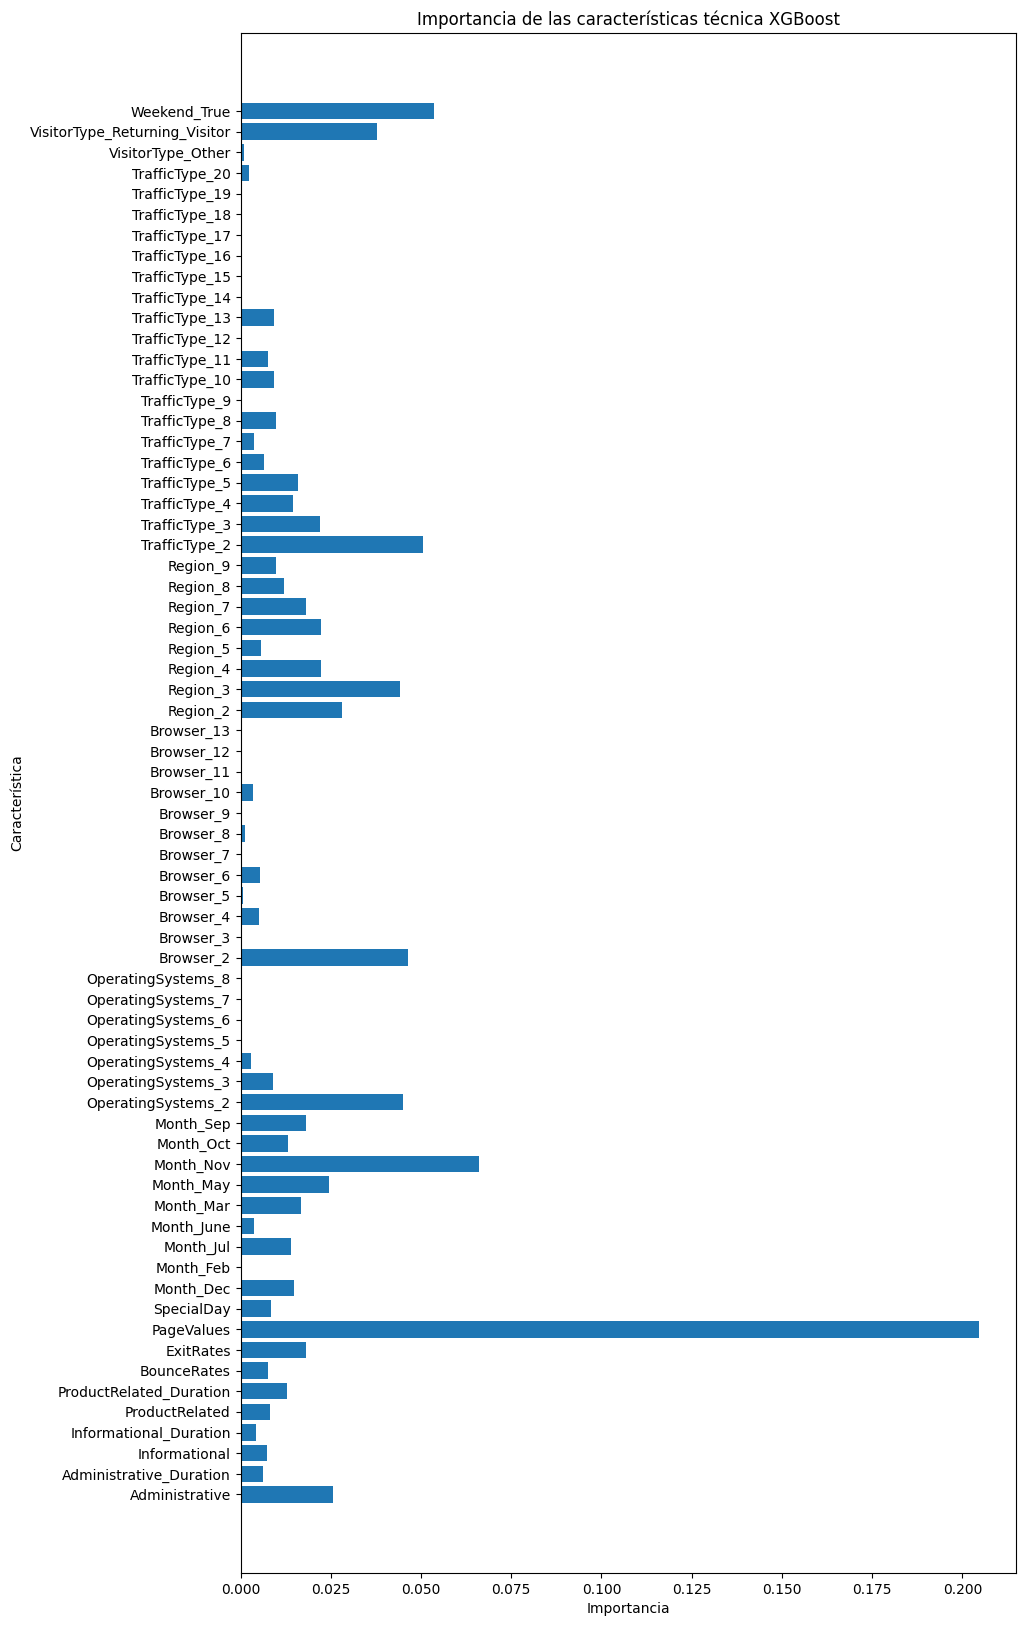

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline
import matplotlib.pyplot as plt

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')


# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', colsample_bytree=0.5, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.9)

# Pipeline con ADASYN para el balanceo de clases
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('model', model)
])

# Entrenamiento del modelo
pipeline.fit(X_train, y_train)

# Evaluación del modelo
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)

# Evaluación de la importancia de las características
feature_names = numeric_features

# Características categóricas del OneHotEncoder
if hasattr(pipeline.named_steps['preprocessor'].transformers_[1][1], 'get_feature_names_out'):
    # Para versiones de scikit-learn 0.24 y posteriores
    cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
else:
    # versionamiento scikit-learn
    cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names(categorical_features)

# todas las características
feature_names.extend(cat_feature_names)

# importancias de las características
importances = pipeline.named_steps['model'].feature_importances_

# Visualización de la importancia de las características
plt.figure(figsize=(10, 20))
plt.barh(feature_names, importances)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características técnica XGBoost')
plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline

# Carga conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv')

# Ingeniería de características avanzada
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Total_Pages'] = data['Administrative'] + data['Informational'] + data['ProductRelated']
data['Pages_Per_Duration'] = data['Total_Pages'] / (data['Total_Duration'] + 1)
data['Admin_Duration_Ratio'] = data['Administrative_Duration'] / (data['Total_Duration'] + 1)
data['Info_Duration_Ratio'] = data['Informational_Duration'] / (data['Total_Duration'] + 1)
data['Product_Duration_Ratio'] = data['ProductRelated_Duration'] / (data['Total_Duration'] + 1)
data['Page_Bounce_Exit_Ratio'] = data['PageValues'] * data['BounceRates'] * data['ExitRates']
data['Admin_Info_Ratio'] = data['Administrative_Duration'] / (data['Informational_Duration'] + 1)

# Convertir 'Month' a numérico
months = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "June": 6,
          "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
data['Month_Num'] = data['Month'].map(months)

# Preprocesamiento
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
                    'Total_Duration', 'Total_Pages', 'Pages_Per_Duration',
                    'Admin_Duration_Ratio', 'Info_Duration_Ratio', 'Product_Duration_Ratio',
                    'Page_Bounce_Exit_Ratio', 'Admin_Info_Ratio', 'Month_Num']
categorical_features = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo XGBoost con el pipeline
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state=42)),
    ('model', model)
])

# Entrenamiento y evaluación del modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Precisión: 0.8905109489051095
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.92      0.95      0.94      2055
        True       0.69      0.62      0.65       411

    accuracy                           0.89      2466
   macro avg       0.81      0.78      0.79      2466
weighted avg       0.89      0.89      0.89      2466



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import ADASYN

# Carga del conjunto de datos
file_path = '/content/drive/MyDrive/Tesis/data/online_shoppers_intention.csv'
data = pd.read_csv(file_path)

# Ingeniería de características avanzada
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']
data['Total_Pages'] = data['Administrative'] + data['Informational'] + data['ProductRelated']
data['Pages_Per_Duration'] = data['Total_Pages'] / (data['Total_Duration'] + 1)
data['Admin_Duration_Ratio'] = data['Administrative_Duration'] / (data['Total_Duration'] + 1)
data['Info_Duration_Ratio'] = data['Informational_Duration'] / (data['Total_Duration'] + 1)
data['Product_Duration_Ratio'] = data['ProductRelated_Duration'] / (data['Total_Duration'] + 1)
data['Page_Bounce_Exit_Ratio'] = data['PageValues'] * data['BounceRates'] * data['ExitRates']
data['Admin_Info_Ratio'] = data['Administrative_Duration'] / (data['Informational_Duration'] + 1)

# Identificar y eliminar características que no contribuyen significativamente
features_to_drop = ['BounceRates', 'ExitRates']
data.drop(features_to_drop, axis=1, inplace=True)

# Definición de características numéricas y categóricas (ajustadas después de eliminar algunas características)
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'PageValues', 'SpecialDay', 'Total_Duration', 'Total_Pages',
                    'Pages_Per_Duration', 'Admin_Duration_Ratio', 'Info_Duration_Ratio',
                    'Product_Duration_Ratio', 'Page_Bounce_Exit_Ratio', 'Admin_Info_Ratio']
categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
                        'VisitorType', 'Weekend']

# División en entrenamiento y prueba
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# Crear modelos individuales
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Ensamblaje de modelos usando VotingClassifier
ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb)],
    voting='soft'
)

# Pipeline con ensamblaje y ADASYN para el balanceo de clases
adasyn = ADASYN(random_state=42, sampling_strategy='auto')
pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('sampling', adasyn),
    ('ensemble', ensemble)
])

# Entrenamiento y evaluación del modelo
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_rep)


Precisión: 0.8969991889699919
Informe de clasificación:
               precision    recall  f1-score   support

       False       0.93      0.95      0.94      2055
        True       0.71      0.64      0.68       411

    accuracy                           0.90      2466
   macro avg       0.82      0.80      0.81      2466
weighted avg       0.89      0.90      0.89      2466



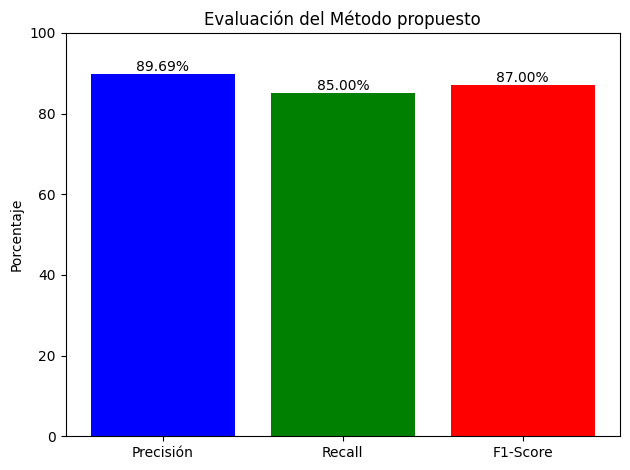

In [ ]:
import matplotlib.pyplot as plt

precision_modelo = 89.69  # Precisión del 89.69%
recall_modelo = 85.00
f1_score_modelo = 87.00

# gráfico de barras
labels = ['Precisión', 'Recall', 'F1-Score']
scores = [precision_modelo, recall_modelo, f1_score_modelo]

fig, ax = plt.subplots()
bars = ax.bar(labels, scores, color=['blue', 'green', 'red'])

# puntuaciones
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center')

# gráfico
plt.ylim(0, 100)  # límite del eje Y para porcentajes
plt.ylabel('Porcentaje')
plt.title('Evaluación del Método propuesto')
plt.tight_layout()

# Mostrar gráfico
plt.show()
